# Import and set colors

In [1]:
#Import packages
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
from gprofiler import gprofiler

import os 

import seaborn as sb
import scvi
from scvi.model.utils import mde
import pymde

Global seed set to 0


In [2]:
#import bbknn

In [3]:
plt.rcParams['figure.figsize']=(4,3) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=False, fontsize=12, color_map='plasma')
sc.logging.print_header()

scanpy==1.9.1 anndata==0.7.8 umap==0.5.3 numpy==1.21.0 scipy==1.8.1 pandas==1.3.0 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 louvain==0.7.1 pynndescent==0.5.7


In [4]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Set project file paths

In [5]:
file_path = '/lustre/groups/ml01/workspace/hananeh.aliee/projects/glial/Glial_170622/' 
#this is my file path please adapt it to your directory

In [6]:
data_dir = file_path + 'data/' 

In [7]:
table_dir = file_path + 'tables_earlytp/'

In [8]:
sc.settings.figdir = file_path + 'figures/'

In [9]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Prepare data for Batch correction

In [13]:
adata_postnorm_no13 = sc.read(data_dir + "adata_postnorm_no13.h5ad")

## scANVI

In [15]:
adata_scANVI_treated= adata_postnorm_no13.copy()
sc.pp.highly_variable_genes(
    adata_scANVI_treated,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [16]:
scvi.model.SCVI.setup_anndata(adata_postnorm_no13, layer="counts", batch_key="batch")

In [17]:
vae = scvi.model.SCVI(adata_postnorm_no13, n_layers=2, n_latent=30, gene_likelihood="nb")
vae.train()
adata_postnorm_no13.obsm["X_scVI"] = vae.get_latent_representation()

/home/icb/hananeh.aliee/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Epoch 145/145: 100%|██████████| 145/145 [6:34:48<00:00, 163.37s/it, loss=6.72e+03, v_num=1] 


In [18]:
adata_postnorm_no13.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata_postnorm_no13, use_rep="X_scVI")
sc.tl.leiden(adata_postnorm_no13)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)


In [21]:
adata_postnorm_no13

AnnData object with n_obs × n_vars = 55216 × 19290
    obs: 'sample_id', 'sample_id_str', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'doublet_score', 'doublet', 'sample', 'experiment', 'size_factors', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'batch_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_id_str_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'cou

In [11]:
adata_postnorm_no13.obsm["X_mde"] = mde(adata_postnorm_no13.obsm["X_scVI"])

Global seed set to 0


In [16]:
adata_postnorm_no13.write(data_dir+ "adata_postnorm_no13_scvi_mde.h5ad",compression='gzip')

In [10]:
adata_postnorm_no13 = sc.read(data_dir + "adata_postnorm_no13_scvi_mde.h5ad")

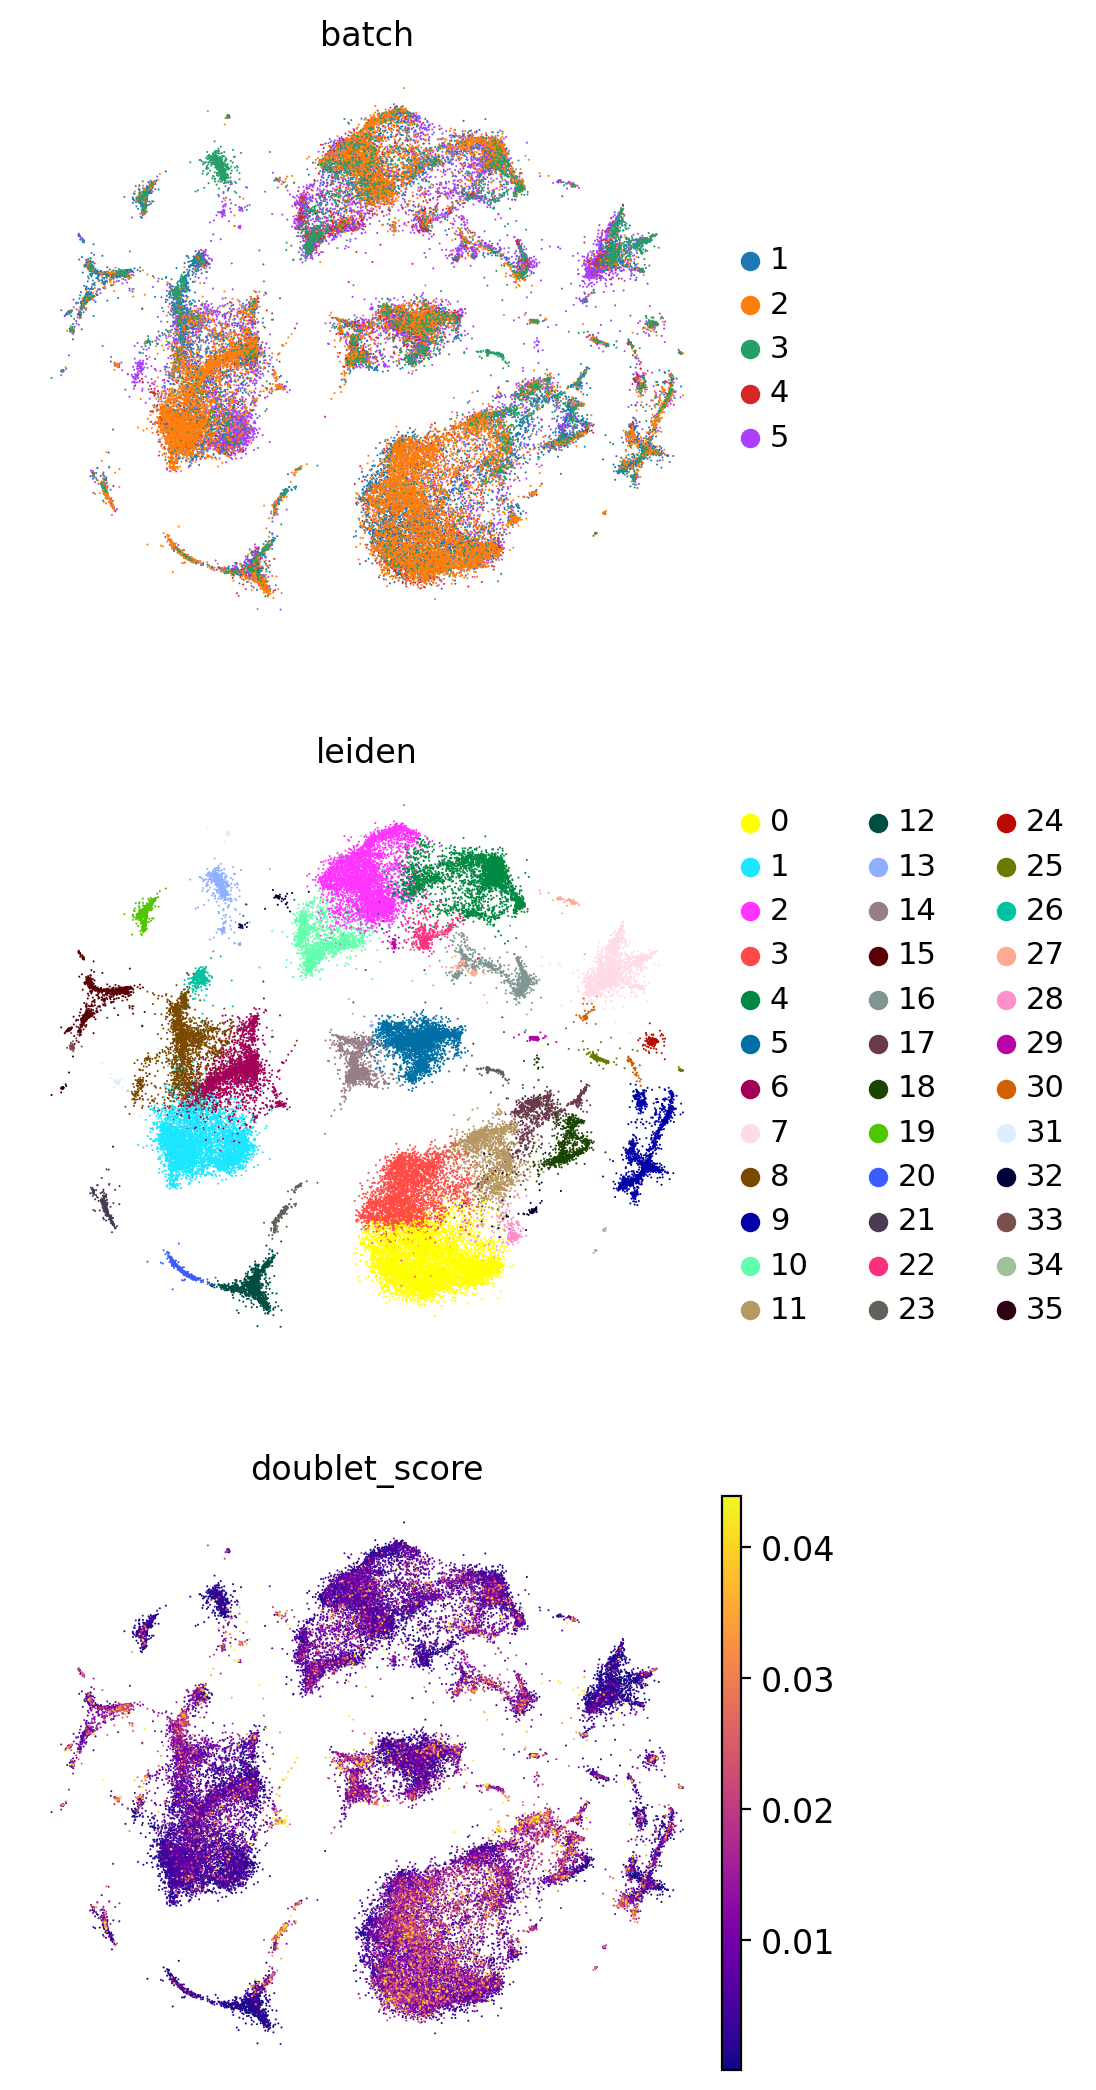

In [12]:
sc.pl.embedding(
    adata_postnorm_no13,
    basis="X_mde",
    color=["batch", "leiden",'doublet_score'],
    frameon=False,
    ncols=1,
)


In [14]:
Christina_genes = ['Sox9','Sox10','Aif1','Rbfox3','Gfap','Gpr17','P2ry12','Slc17a7','Aldh1l1','Mag','Cx3cr1','Gabra1','Atp1b2','Pdgfra', 'Cd68', 'Serpina3n', 'Lcn2']

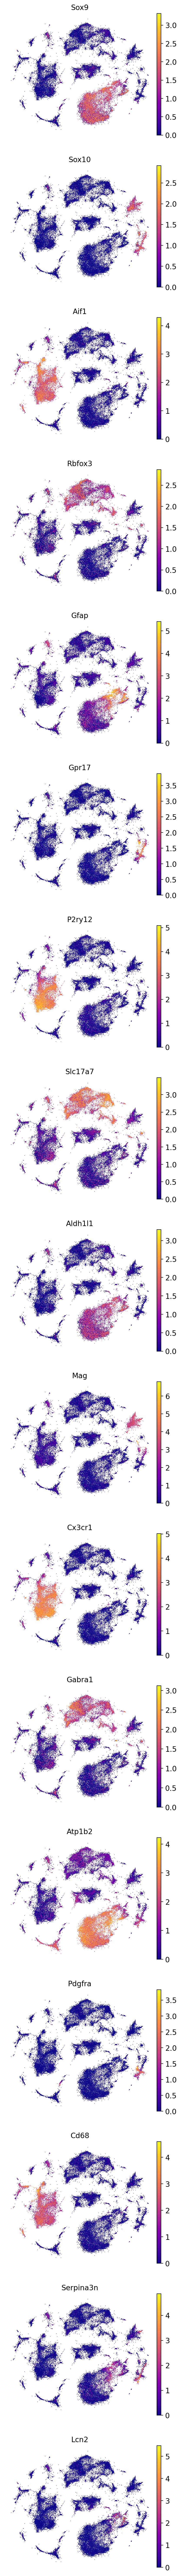

In [15]:
sc.pl.embedding(
    adata_postnorm_no13,
    basis="X_mde",
    color=Christina_genes,
    frameon=False,
    ncols=1,
)


In [13]:
adata_postnorm_no13

AnnData object with n_obs × n_vars = 55216 × 19290
    obs: 'sample_id', 'sample_id_str', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'doublet_score', 'doublet', 'sample', 'experiment', 'size_factors', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_id_str_colors', 'umap'
    obsm: 'X_mde', 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'coun